# Лабораторная работа 3
### Выполнил: Сазиков Максим Дмитриевич

Добро пожаловать в третью лабораторную работу!
Оформите ваше решение контеста Kaggle в соответствии с этим шаблоном. Ваша задача - показать проверяющим ход ваших рассуждений, поэтому советуем писать много комментариев к коду и приводить комментарии к логике на каждом этапе в текстовых ячейках.
Где необходимо, используйте графики для большей наглядности.

При отправке поменяйте название файла на ваши ФИО!

### Настройка Google Colab

Подключение вашего гугл диска (советуем сохранять все важные артефакты именно на диск, чтобы они не удалились при закрытии вкладки с ноутбуком).

In [28]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### EDA (исследовательский анализ данных)

В этой лабораторной вы работаете с картинками. Напишите функцию, которая отрисовывала бы ключевые точки на конкретном изображении, это вам пригодится для дебага.
Можете посчитать статистики по картинкам в датасете.

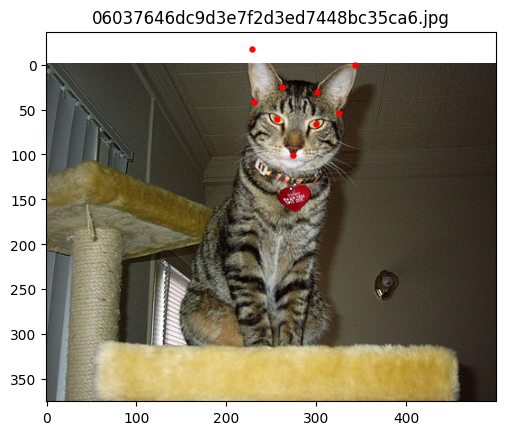

In [30]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

# Пути к данным
TRAIN_IMAGES_DIR = '/content/drive/My Drive/Машинка/lab3/images/images/train'
TRAIN_LABELS_PATH = '/content/drive/My Drive/Машинка/lab3/train_labels.csv'

train_labels_df = pd.read_csv(TRAIN_LABELS_PATH)
image_files = [f for f in os.listdir(TRAIN_IMAGES_DIR) if os.path.isfile(os.path.join(TRAIN_IMAGES_DIR, f)) and f.lower().endswith(('.png', '.jpg', '.jpeg'))]
train_labels_df = train_labels_df[train_labels_df['file_name'].isin(image_files)]

def plot_keypoints(image_index, df, images_dir):
    row = df.iloc[image_index]
    image_name = row['file_name']
    keypoints = row[:-1].values.tolist()
    image_path = os.path.join(images_dir, image_name)

    image = Image.open(image_path)
    plt.imshow(image, cmap='gray')
    keypoints = np.array(keypoints).reshape(-1, 2)
    plt.scatter(keypoints[:, 0], keypoints[:, 1], s=50, marker='.', c='red')
    plt.title(image_name)
    plt.show()

plot_keypoints(10, train_labels_df, TRAIN_IMAGES_DIR)

Изначально я подумал, что отрицательные значения - выбросы, но на этой картине видно, что ухо действительно заканчивается за границами

### Preprocessing (подготовка данных)

Мы ожидаем, что в этом разделе вы реализуете кастомный класс для подгрузки данных (cоветуем унаследоваться от `torch.utils.data.Dataset`).

In [31]:
import torch.utils
class CatKeypointsDataset(torch.utils.data.Dataset):
    def __init__(self, images_dir, file_names, labels_df=None, transforms=None):
        self.images_dir = images_dir
        self.transforms = transforms
        self.file_names = file_names
        self.labels_df = labels_df

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, idx):
        img_name = os.path.join(self.images_dir, self.file_names[idx])
        image = Image.open(img_name).convert("L")
        original_size = image.size

        if self.transforms:
            image = self.transforms(image)

        if self.labels_df is not None:
            keypoints = self.labels_df[self.labels_df['file_name'] == self.file_names[idx]].iloc[0, :-1].values.astype('float32').reshape(-1, 2)

            # Масштабирование координат ключевых точек
            keypoints[:, 0] = keypoints[:, 0] / original_size[0] * IMAGE_SIZE[0]
            keypoints[:, 1] = keypoints[:, 1] / original_size[1] * IMAGE_SIZE[1]

            return image, torch.tensor(keypoints).flatten()
        else:
            return image, self.file_names[idx]

### Training/evaluation loop

В этом разделе напишите функцию, принимающую модель, оптимизатор, кол-во эпох, и т.д, которая осуществляет обучение с заданными параметрами. Подумайте, что функция будет возвращать.

Смысл этого раздела в том, чтобы не дублировать код обучения для каждого эксперимента. А еще на такую функцию легко накинуть перебор гиперпараметров...

In [32]:
### function for training


def train_model(model, train_dataloader, val_dataloader, criterion, optimizer, num_epochs, device="cpu", scheduler=None):
    model.to(device)

    l1_history_train = []
    l1_history_val = []

    for epoch in range(num_epochs):
        # Обучение
        model.train()
        epoch_l1_train = 0
        with tqdm(train_dataloader, unit="batch", desc=f"Epoch {epoch+1}/{num_epochs} [Train]") as tepoch:
            for batch_idx, (data, target) in enumerate(tepoch):
                data, target = data.to(device), target.to(device)
                optimizer.zero_grad()
                output = model(data)
                loss = criterion(output, target)
                loss.backward()
                optimizer.step()

                epoch_l1_train += loss.item()

                tepoch.set_postfix(l1=loss.item())

        l1_history_train.append(epoch_l1_train / len(train_dataloader))

        # Валидация
        model.eval()
        epoch_l1_val = 0
        with torch.no_grad():
            with tqdm(val_dataloader, unit="batch", desc=f"Epoch {epoch+1}/{num_epochs} [Val]") as vepoch:
                for batch_idx, (data, target) in enumerate(vepoch):
                    data, target = data.to(device), target.to(device)
                    output = model(data)
                    loss = criterion(output, target)

                    epoch_l1_val += loss.item()

                    vepoch.set_postfix(l1=loss.item())

        l1_history_val.append(epoch_l1_val / len(val_dataloader))

        if scheduler:
            scheduler.step()

        # Отрисовка графиков
        clear_output(wait=True)
        plt.plot(l1_history_train, label='Train L1')
        if l1_history_val:
            plt.plot(l1_history_val, label='Validation L1')
        plt.title('L1 Loss')
        plt.legend()
        plt.show()

        print(f"Epoch: {epoch+1}/{num_epochs}, Train L1: {l1_history_train[-1]:.4f}")
        if l1_history_val:
            print(f"Validation L1: {l1_history_val[-1]:.4f}")

    return {
        "train_l1": l1_history_train,
        "val_l1": l1_history_val,
    }

### Prediction function

Реализуйте функцию, которая бы делала предсказания. Функция принимает датасет/даталоадер и модель (мб еще что-то). Эта функция нужна вам, чтобы было удобнее считать метрику (по сути она будет склеивать предсказания из батчей в один массив).

In [33]:
### function for making predictions

def predict(model, dataloader, device="cuda"):
    model.to(device)
    model.eval()
    all_predictions = []

    with torch.no_grad():
        for data, _ in tqdm(dataloader, desc="Predicting"):
            data = data.to(device)
            output = model(data)
            all_predictions.append(output.cpu().numpy())

    return np.concatenate(all_predictions, axis=0)

### Experiments

В этом разделе задаете архитектуры моделей и ставите эксперименты по обучению. Мы ожидаем, что вы зададите модель в виде класса (унаследуетесь от класса `torch.nn.Module`).

Если вы ставили много экспериментов, приведите их в хронологическом порядке, чтобы мы увидели эволюцию ваших рассуждений.

Мы ожидаем увидеть графики train/val лоссов и метрик для ваших экспериментов. Мы ожидаем увидеть визуализацию примеров предсказаний.

#### Эксперимент 1

Модель BasicCNN представляет собой последовательность следующих слоев:

1. Сверточный слой: Извлекает признаки из входного изображения, используя заданное ядро свертки.
2. Слой Batch Normalization: Нормализует выходные данные сверточного слоя для ускорения и стабилизации обучения.
3. Слой Max Pooling: Уменьшает пространственное разрешение карт признаков, выделяя наиболее важные признаки и снижая вычислительную нагрузку.
4. Сверточный слой: Продолжает извлекать более сложные признаки из карт признаков, полученных на предыдущем этапе.
5. Слой Batch Normalization: Нормализует выходные данные второго сверточного слоя.
6. Слой Max Pooling: Дальнейшее уменьшение пространственного разрешения.
7. Сверточный слой: Извлекает еще более абстрактные признаки.
8. Слой Batch Normalization: Нормализует выходные данные третьего сверточного слоя.
9. Слой Max Pooling: Финальное уменьшение пространственного разрешения перед полносвязными слоями.
10. Полносвязный слой: Устанавливает связи между всеми признаками, полученными на сверточных слоях, и преобразует их в вектор более высокого уровня.
11. Полносвязный слой: Выводит окончательные предсказания координат ключевых точек.

В процессе прямого прохода (forward), после каждого сверточного слоя и перед слоем Max Pooling применяется функция активации ReLU для добавления нелинейности.

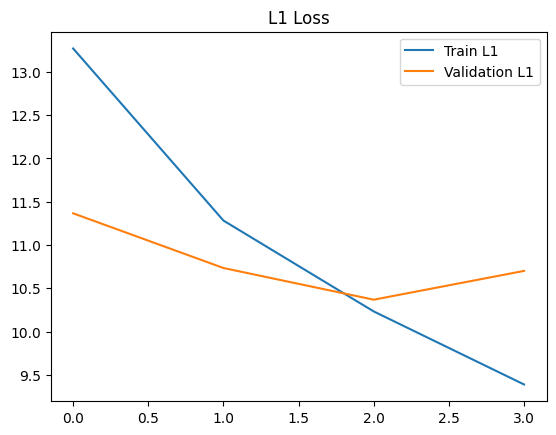

Epoch: 4/4, Train L1: 9.3895
Validation L1: 10.7010
CPU times: user 16min 17s, sys: 2min 1s, total: 18min 19s
Wall time: 23min 49s


In [34]:
%%time
# some code and comments
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.v2 as T
from PIL import Image
import os
import copy
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
import pandas as pd
from sklearn.model_selection import train_test_split

class BasicCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 16 * 16, 512)
        self.fc2 = nn.Linear(512, 18)

    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))
        x = x.view(-1, 64 * 16 * 16)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


IMAGE_SIZE = (128, 128)
BATCH_SIZE = 32
NUM_EPOCHS = 4
LEARNING_RATE = 1e-3

train_transforms = T.Compose([
    T.Resize(IMAGE_SIZE),
    T.ToImage(),
    T.ToDtype(torch.float, scale=True),
])

val_transforms = T.Compose([
    T.Resize(IMAGE_SIZE),
    T.ToImage(),
    T.ToDtype(torch.float, scale=True),
])

# Разделение тренировочного датасета на тренировочный и валидационный
train_images_names, val_images_names, train_labels_exp1, val_labels_exp1 = train_test_split(
    train_labels_df['file_name'].tolist(),
    train_labels_df,
    test_size=0.2,
    random_state=42
)

train_dataset_exp1 = CatKeypointsDataset(TRAIN_IMAGES_DIR, train_images_names, train_labels_exp1, transforms=train_transforms)
val_dataset_exp1 = CatKeypointsDataset(TRAIN_IMAGES_DIR, val_images_names, val_labels_exp1, transforms=val_transforms)

train_dataloader_exp1 = torch.utils.data.DataLoader(train_dataset_exp1, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader_exp1 = torch.utils.data.DataLoader(val_dataset_exp1, batch_size=BATCH_SIZE, shuffle=False)

# Инициализация модели, функции потерь и оптимизатора:

model_exp1 = BasicCNN()
criterion_exp1 = nn.L1Loss()
optimizer_exp1 = torch.optim.Adam(model_exp1.parameters(), lr=LEARNING_RATE)

# Запуск обучения
device = "cuda" if torch.cuda.is_available() else "cpu"
training_history_exp1 = train_model(
    model_exp1,
    train_dataloader_exp1,
    val_dataloader_exp1,
    criterion_exp1,
    optimizer_exp1,
    NUM_EPOCHS,
    device=device
)

### Evaluation  (оценка качества модели)

В этом разделе проводите оценку качества вашей итоговой модели (с помощью prediction function из раздела выше).

In [35]:
# model evaluation
predicted_keypoints_val_exp1 = predict(model_exp1, val_dataloader_exp1, device=device)
true_keypoints_val_exp1 = np.concatenate([y.numpy() for _, y in val_dataloader_exp1], axis=0)
l1_loss_val_predictions_exp1 = nn.functional.l1_loss(torch.tensor(predicted_keypoints_val_exp1), torch.tensor(true_keypoints_val_exp1)).item()
print(f"L1 Loss на валидационном наборе (Experiment 1): {l1_loss_val_predictions_exp1:.4f}")

Predicting: 100%|██████████| 57/57 [00:43<00:00,  1.30it/s]


L1 Loss на валидационном наборе (Experiment 1): 10.7488


CMAE почти не отличается от L1 Loss при большом колличестве данных. Однако сейчас оцениваются предсказания на картинках приведённых к размеру 128x128, поэтому в контесте получается примерно в 5 раз больше (т.к. средний размер картинок в 5 раз больше)

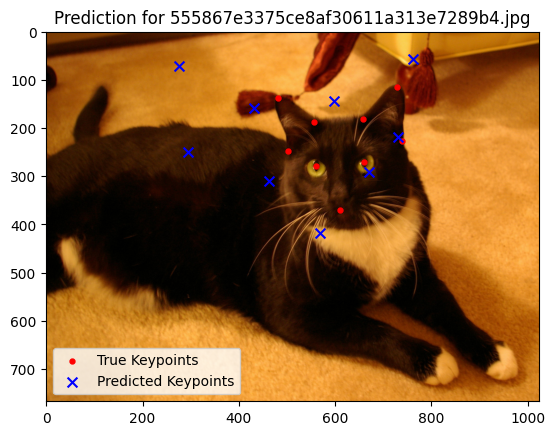

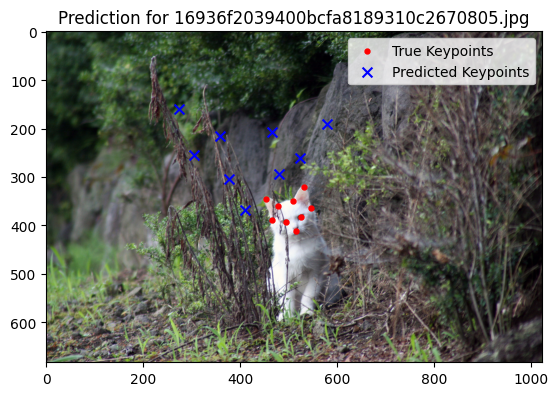

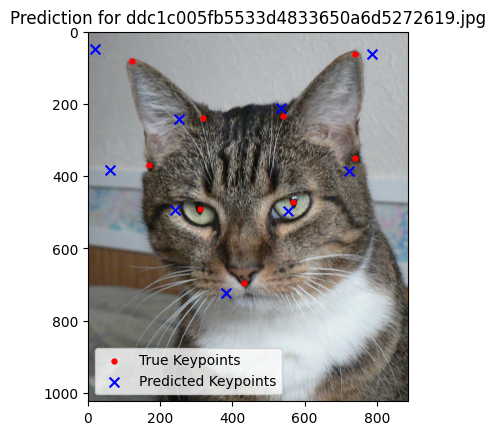

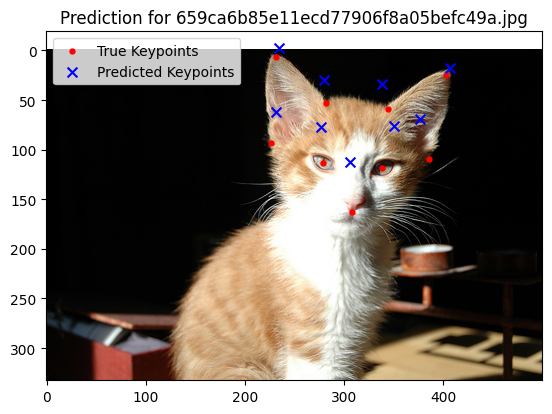

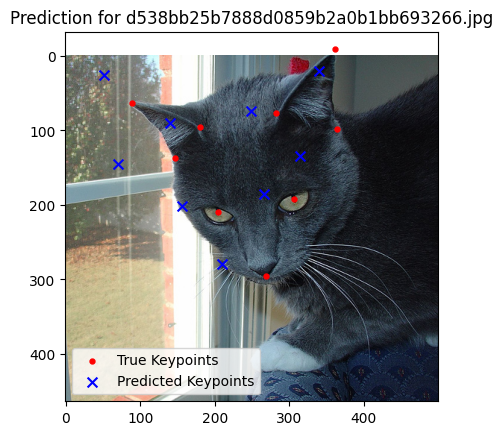

In [36]:
def plot_predicted_keypoints(image_index, true_df, predicted_keypoints, images_dir):
    row = true_df.iloc[image_index]
    image_name = row['file_name']
    true_keypoints = row[:-1].values.tolist()
    image_path = os.path.join(images_dir, image_name)

    image = Image.open(image_path)
    original_width, original_height = image.size
    plt.imshow(image, cmap='gray')

    true_keypoints = np.array(true_keypoints).reshape(-1, 2)
    plt.scatter(true_keypoints[:, 0], true_keypoints[:, 1], s=50, marker='.', c='red', label='True Keypoints')

    predicted_kpts_scaled = predicted_keypoints[image_index].reshape(-1, 2)

    predicted_kpts_original_scale = predicted_kpts_scaled.copy()
    predicted_kpts_original_scale[:, 0] = predicted_kpts_scaled[:, 0] / IMAGE_SIZE[0] * original_width
    predicted_kpts_original_scale[:, 1] = predicted_kpts_scaled[:, 1] / IMAGE_SIZE[1] * original_height

    plt.scatter(predicted_kpts_original_scale[:, 0], predicted_kpts_original_scale[:, 1], s=50, marker='x', c='blue', label='Predicted Keypoints')

    plt.title(f"Prediction for {image_name}")
    plt.legend()
    plt.show()

import random

num_samples_to_visualize = 5
num_val_samples = len(val_labels_exp1)
num_samples_to_visualize = min(num_samples_to_visualize, num_val_samples)

random_indices = random.sample(range(num_val_samples), num_samples_to_visualize)

for i in random_indices:
    plot_predicted_keypoints(i, val_labels_exp1, predicted_keypoints_val_exp1, TRAIN_IMAGES_DIR)



Видно, что сеть не замечает поворота головы (стоило добавить в тренировочные данные случайный поворот), а сдвиг скорее всего связан с недостаточным обучением.

### Conclusion (Выводы)

В этом разделе описываете полученные результаты и проводите анализ выполненной работы.
Что получилось / не получилось и почему?

Получилось создать рабочую нейронную сеть, которая преодолела baseline. Я пробовал увеличивать разрешение картинок, использовать цветные картинки, перебирал гиперпараметры в ручную, но всё это почему-то только ухудшало результат. Возможно, дело в структуре самой сети. Я не стал долго её обучать, т.к. изменений почти не было, а результат в целом далёк от первых мест. Была идея использовать 2 сети: 1) для обнаружения головы, 2) поиск точек на обрезанной голове. Но слишком поздно об этом подумал